# *grama* Analysis Demo

---

*grama* is a *grammar of model analysis*---a language for describing and analyzing mathematical models. Heavily inspired by [ggplot](https://ggplot2.tidyverse.org/index.html), `py_grama` is a Python package that implements *grama* by providing tools for defining and exploring models. 

This notebook illustrates how one can use *grama* to ***analyze a fully-defined model***.

Note that you will need to install `py_grama`, a fork of `dfply`, and dependencies in order to run this notebook. See the [installation instructions](https://github.com/zdelrosario/py_grama) for details. 

In [1]:
### Setup
from dfply import *
import grama as gr
import numpy as np
import pandas as pd
import seaborn as sns

# Quick Tour: Analyzing a model

---

*grama* separates the model *definition* from model *analysis*; once the model is fully defined, only minimal information is necessary for further analysis.

As a quick demonstration, we import a fully-defined model provided with *grama*, and carry out a few analyses.

In [2]:
from grama.models import make_cantilever_beam

md_beam = make_cantilever_beam()
md_beam.printpretty()

model: Cantilever Beam

  inputs:
    var_det:
      w: [2, 4]
      t: [2, 4]
    var_rand:
      H: (+1) norm, {'loc': 500.0, 'scale': 100.0}
      V: (+1) norm, {'loc': 1000.0, 'scale': 100.0}
      E: (+0) norm, {'loc': 29000000.0, 'scale': 1450000.0}
      Y: (-1) norm, {'loc': 40000.0, 'scale': 2000.0}
  functions:
    cross-sectional area: ['w', 't'] -> ['c_area']
    limit state: stress: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_stress']
    limit state: displacement: ['w', 't', 'H', 'V', 'E', 'Y'] -> ['g_disp']


The method `printpretty()` gives us a quick summary of the model; we can see this model has two deterministic variables `w,t` and four random variables `H,V,E,Y`. All of the variables affect the outputs `g_stress, g_displacement`, while only `w,t` affect `c_area`. Since there are random variables, there is a source of *uncertainty* which we must consider when studying this model.

## Studying model behavior with uncertainty

Since the model has sources of randomness (`var_rand`), we must account for this when studying its behavior. We can do so through a Monte Carlo analysis. We make decisions about the deterministic inputs by specifying `df_det`, and the `py_grama` function `gr.ev_monte_carlo` automatically handles the random inputs. Below we fix a nominal value `w = 0.5 * (2 + 4)`, sweep over values for `t`, and account for the randomness via Monte Carlo.

In [3]:
## Generate data for deterministic variables
df_beam_det = pd.DataFrame(
    data={
        "w": [0.5 * (2 + 4)] * 10,
        "t": np.linspace(2.5, 3, num=10)
    }
)

## Carry out a Monte Carlo analysis of the random variables
df_beam_mc = \
    md_beam >> \
    gr.ev_monte_carlo(n=1e2, df_det=df_beam_det)

eval_monte_carlo() is rounding n...


To help plot the data, we use `dfply` to wrange the data, and `seaborn` to quickly visualize results.

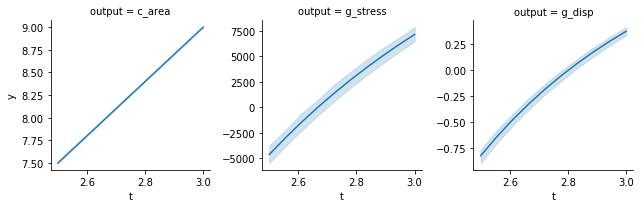

In [4]:
df_beam_wrangled = \
    df_beam_mc >> \
    gather("output", "y", ["c_area", "g_stress", "g_disp"])

g = sns.FacetGrid(df_beam_wrangled, col="output", sharey=False)
g.map(sns.lineplot, "t", "y")

The mean behavior of the model is shown as a solid line, while the band visualizes the standard deviation of the model output. From this plot, we can see:

- The random variables have no effect on `c_area` (there is no band)
- Comparing `g_stress` and `g_displacement`, the former is more strongly affected by the random inputs, as illustrated by its wider uncertainty band.

While this provides a visual description of how uncertainty affects our outputs, we might be interested in *how* the different random variables affect our outputs.

## Probing random variable effects

One way to quantify the effects of random variables is through *Sobol' indices*, which quantify variable importance by the fraction of output variance "explained" by each random variable. Since distribution information is included in the model, we can carry out a *hybrid-point Monte Carlo* and analyze the results with two calls to `py_grama`.

In [5]:
df_sobol = \
    md_beam >> \
    gr.ev_hybrid(n=1e3, df_det="nom", seed=101) >> \
    gr.tf_sobol()

df_sobol

eval_hybrid() is rounding n...


,g_disp,c_area,g_stress,ind
0,0.28,0.0,-0.03,S_E
0,0.21,0.0,0.35,S_H
0,0.64,0.0,0.33,S_V
0,0.02,0.0,0.31,S_Y


The indices should lie between `[0, 1]`, but estimation error can lead to violations. These results suggest that `g_stress` is largely insensitive to `E`, while `g_disp` is insensitive to `Y`. For `g_disp`, the input `V` contributes about twice the variance as variables `H,E`.

To get a *qualitative* sense of how the random variables affect our model, we can perform a set of sweeps over random variable space with a *sinew* design. First, we visualize the design in the four-dimensional random variable space of `[H,V,E,Y]`.

Estimated runtime for design with model (Cantilever Beam):
  0.0101 sec


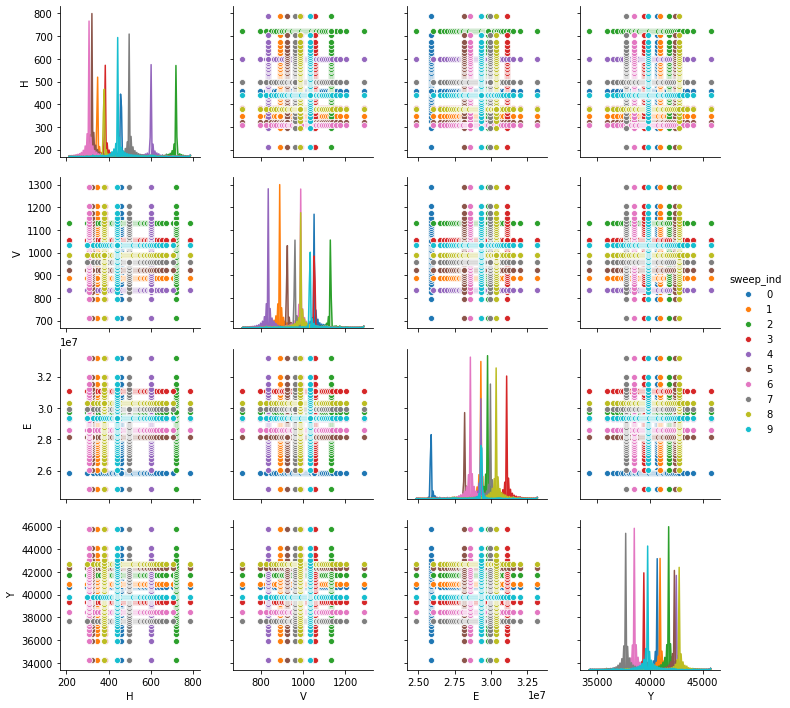

In [6]:
md_beam >> \
    gr.ev_sinews(n_density=50, n_sweeps=10, df_det="nom", skip=True) >> \
    gr.pt_auto()

The `skip` keyword argument allows us to delay evaluating a model; this is useful for inspecting a design before running a potentially expensive calculation. The `pt_auto()` function automatically detects DataFrames generated by `py_grama` functions and constructs an appropriate visualization. This is provided for convenience; you are of course welcome (and encouraged!) to create your own visualizations of the data.

Here we can see the sweeps cross the domain in straight lines at random starting locations. Each of these sweeps gives us a "straight shot" within a single variable. Visualizing the outputs for these sweeps will give us a sense of a single variable's influence, contextualized by the effects of the other random variables.

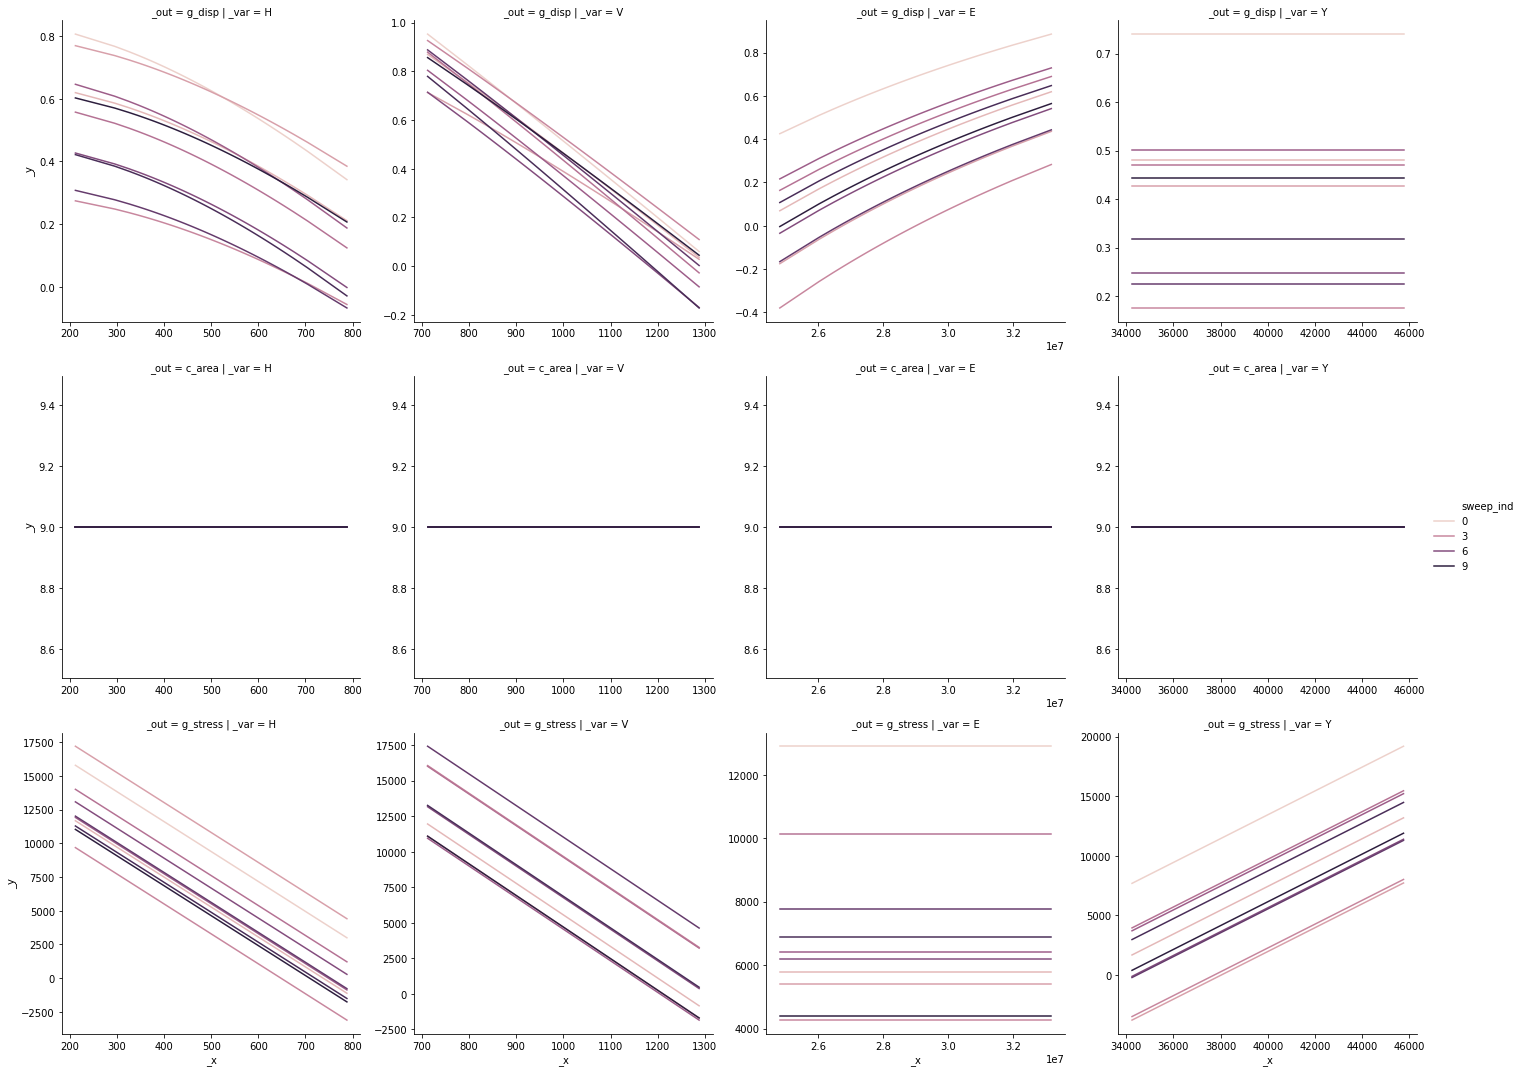

In [7]:
df_beam_sweeps = \
    md_beam >> \
    gr.ev_sinews(n_density=50, n_sweeps=10, df_det="nom")

df_beam_sweeps >> gr.pt_auto()

Removing the keyword argument `skip` falls back on the default behavior; the model functions are evaluated at each sample, and `pt_auto()` adjusts to use this new data.

Based on this plot, we can see:

- The output `c_area` is insensitive to all the random variables
- As the Sobol' analyis above suggested `g_stress` is insensitive to `E`, and `g_displacement` is insensitive to `Y`
- Visualizing the results shows that inputs `H,E` tend to 'saturate' in their effects on `g_displacement`, while `V` is linear over its domain. This may explain the difference in contributed variance

# Theory: The *grama* language

---

As a language, *grama* has both *objects* and *verbs*. 

### Objects

---

*grama* as a language considers two categories of objects:

- **data** (`df`): observations on various quantities, implemented by the Python package `Pandas`
- **models** (`md`): a function and complete description of its inputs, implemented by `py_grama`

For readability, we suggest using prefixes `df_` and `md_` when naming DataFrames and models. 

Since data is already well-handled by Pandas, `py_grama` focuses on providing tools to handle models. A `py_grama` model has **functions** and **inputs**:  The method `printpretty()` gives a quick summary of the model's inputs and function outputs. Model inputs are organized into:

|            | Deterministic                            | Random     |
| ---------- | ---------------------------------------- | ---------- |
| Variables  | `model.var_det`                          | `model.var_rand` |
| Parameters | `model.density.marginals[i].d_param`     | (Future*)  |

- **Variables** are inputs to the model's functions
  + **Deterministic** variables are chosen by the user; the model above has `w, t`
  + **Random** variables are not controlled; the model above has `H, V, E, Y`
- **Parameters** define random variables
  + **Deterministic** parameters are currently implemented; these are listed under `var_rand` with their associated random variable
  + **Random** parameters* are not yet implemented

The `outputs` section lists the various model outputs. The model above has `c_area, g_stress, g_displacement`.

### Verbs

---

Verbs are used to take action on different *grama* objects. We use verbs to generate data from models, build new models from data, and ultimately make sense of the two.

The following table summarizes the categories of `py_grama` verbs. Verbs take either data (`df`) or a model (`md`), and may return either object type. The prefix of a verb immediately tells one both the input and output types. The short prefix is used to denote the *pipe-enabled version* of a verb.

| Verb Type | Prefix (Short)  | In   | Out   |
| --------- | --------------- | ---- | ----- |
| Evaluate  | `eval_` (`ev_`) | `md` | `df`  |
| Fit       | `fit_`  (`ft_`) | `df` | `md`  |
| Transform | `tran_` (`tf_`) | `df` | `df`  |
| Compose   | `comp_` (`cp_`) | `md` | `md`  |

### Functional programming (Pipes)

---

`py_grama` provides tools to use functional programming patterns. Short-stem versions of `py_grama` functions are *pipe-enabled*, meaning they can be used in functional programming form with the pipe operator `>>`. These pipe-enabled functions are simply aliases for the base functions, as demonstrated below:

In [8]:
df_base = gr.eval_nominal(md_beam, df_det="nom")
df_functional = md_beam >> gr.ev_nominal(df_det="nom")

df_base.equals(df_functional)

True

Functional patterns enable chaining multiple commands, as demonstrated in the Sobol' index code above. In nested form using base functions, this would be:

```python
df_sobol = gr.tran_sobol(gr.eval_hybrid(md_beam, n=1e3, df_det="nom", seed=101))
```

From the code above, it is difficult to see that we first consider `md_beam`, perform a hybrid-point evaluation, then use those data to estimate Sobol' indices. With more chained functions, this only becomes more difficult. One could make the code significantly more readable by introducing intermediate variables:

```python
df_samples = gr.eval_hybrid(md_beam, n=1e3, df_det="nom", seed=101)
df_sobol = gr.tran_sobol(df_samples)
```

Conceptually, using *pipe-enabled* functions allows one to skip assigning intermediate variables, and instead pass results along to the next function. The pipe operator `>>` inserts the results of one function as the first argument of the next function. A pipe-enabled version of the code above would be:

```python
df_sobol = \
    md_beam >> \
    gr.ev_hybrid(n=1e3, df_det="nom", seed=101) >> \
    gr.tf_sobol()
```

The other advantage of using functional patterns with the `>>` pipe is that `py_grama` functions can then be chained with functions from `dfply`, which provides pipe-enabled calls to `Pandas` functions. This allows us to combine *data science* tools with *model analysis tools*.

Note: It appears that the original [dfply](https://github.com/kieferk/dfply) may no longer be updated; I have forked [my own version](https://github.com/zdelrosario/dfply) which I will maintain to support `py_grama`.